In [ ]:

library(survival) 
library(mgcv) 
library(readxl)
library(glmnet)
library(survival)
library(xlsx)
library(discSurv)
library(Hmisc)
library(randomForestSRC)
library(ggRandomForests)
library(caret)
library(pec)


In [16]:
train <- data.frame(read_excel("Data_clean.agegr.trn.xlsx"))
train <- subset(train, select = -c(id))

test <- data.frame(read_excel("Data_clean.agegr.tst.xlsx"))
test<- subset(test,select=-c(id))

IntBorders <- 1:ceiling(max(train$OS))
data.train <- contToDisc (dataSet=train, timeColumn="OS", intervalLimits=IntBorders)

data.train[1:7,1:5]


timeDisc,OS,Status.OS,Grade,Age
75,74.277267,0,1,34.3
28,27.660972,0,2,73.0
52,51.938239,1,2,46.4
44,43.626807,0,2,42.0
18,17.936925,0,3,65.0
5,4.830541,1,3,39.1
46,45.433640,0,3,69.9


In [17]:
Long <- dataLong (dataSet=data.train, timeColumn="timeDisc", censColumn="Status.OS")
#turn var in factors if neccesary, we do it later so not needed anymore

Long$timeInt <- as.factor(Long$timeInt)
Long$Grade <- as.factor(Long$Grade)
Long$y<-as.factor(Long$y)

#only select needed variables for regression

#long<-Long[,7:1034]
#x<-as.matrix.data.frame(long)

Long[1:9,1:8]


,obj,timeInt,y,timeDisc,OS,Status.OS,Grade,Age
1,1,1,0,75,74.27727,0,1,34.3
1.1,1,2,0,75,74.27727,0,1,34.3
1.2,1,3,0,75,74.27727,0,1,34.3
1.3,1,4,0,75,74.27727,0,1,34.3
1.4,1,5,0,75,74.27727,0,1,34.3
1.5,1,6,0,75,74.27727,0,1,34.3
1.6,1,7,0,75,74.27727,0,1,34.3
1.7,1,8,0,75,74.27727,0,1,34.3
1.8,1,9,0,75,74.27727,0,1,34.3


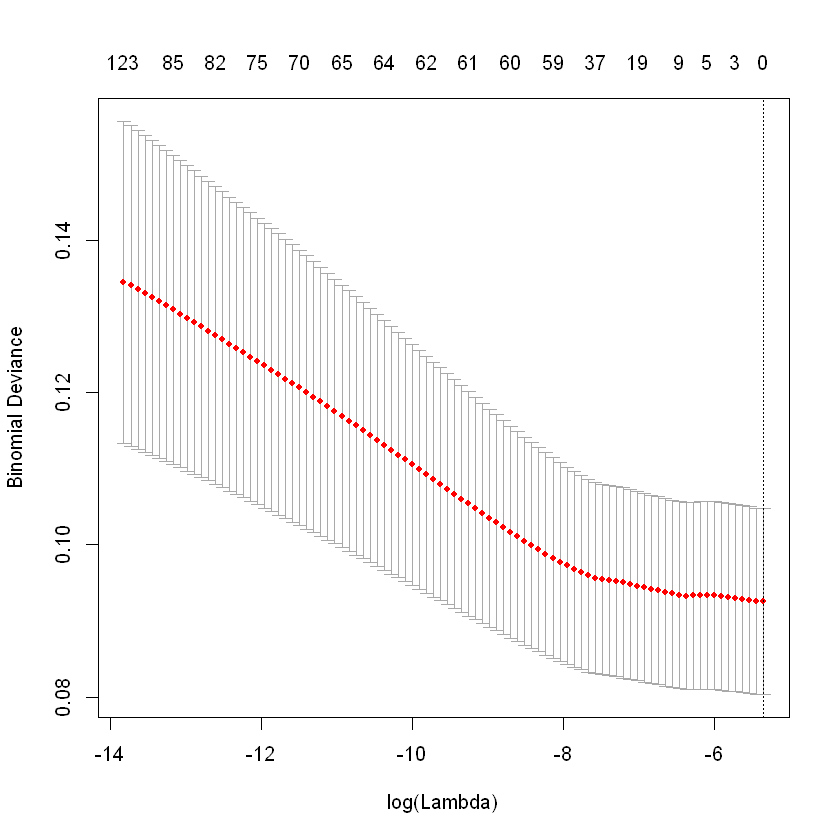

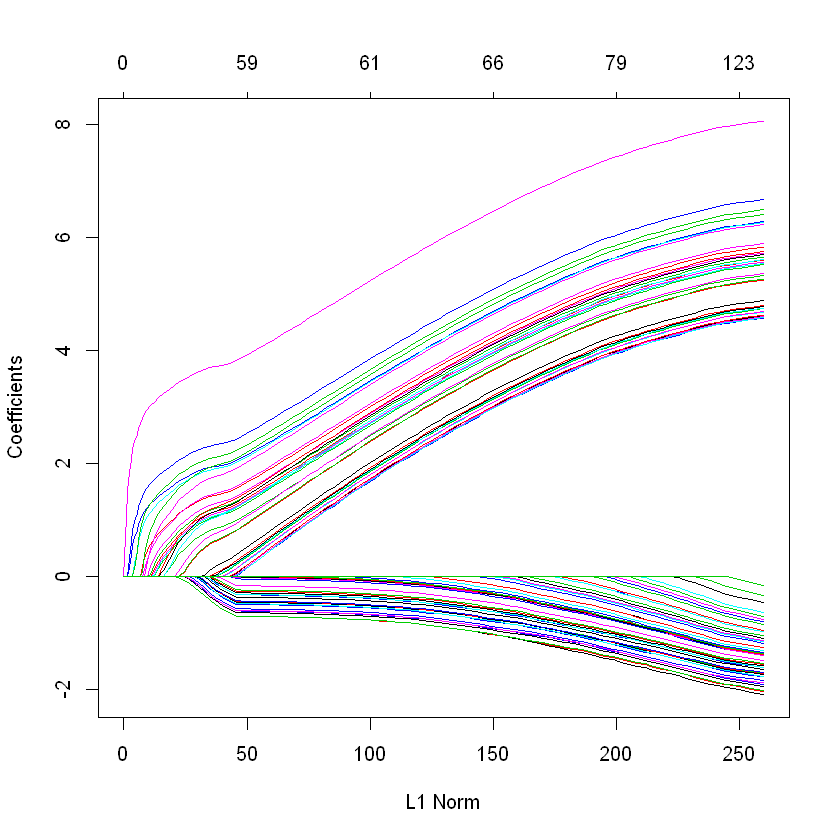

In [18]:

#xfactors <- model.matrix(Long$y ~ Long$timeInt+Long$Grade)[, -1]
#x        <- as.matrix(data.frame(xfactors, Long[,8:1034]))

xfactors <- model.matrix(Long$y ~ Long$timeInt)[, -1]
x        <- as.matrix(data.frame(xfactors))

# Note alpha=1 for lasso only and can blend with ridge penalty down to
# alpha=0 ridge only.

glmm.cv <- cv.glmnet(x, y=as.factor(Long$y), alpha=1, family="binomial")
plot(glmm.cv)
glmm <- glmnet(x, y=as.factor(Long$y), alpha=1, family="binomial")
plot(glmm)
best_lambda <- glmm.cv$lambda[which.min(glmm.cv$cvm)]
#print(glmm)



In [15]:
Coefficients <- coef(glmm, s = glmm.cv$lambda.min)  
Active.Index <- which(Coefficients != 0)
Active.Coefficients <- Coefficients[Active.Index]
Active.Index
names(Long[,Active.Index+7])
Active.Coefficients


[1]  1 11 36 47 52 85

[1] "Age"                                         
[2] "original_shape_MajorAxis"                    
[3] "original_glcm_JointAverage"                  
[4] "original_glcm_Imc1"                          
[5] "original_glcm_Idn"                           
[6] "original_glszm_SmallAreaLowGrayLevelEmphasis"

[1] -4.9310978  0.9985763  0.7405639  1.3272198  0.8288937  2.7106649

In [35]:
# add new columns to test data

data.test <- contToDisc (dataSet=test, timeColumn="OS", intervalLimits=IntBorders)
Long.test <- dataLong (dataSet=data.test, timeColumn="timeDisc", censColumn="Status.OS")

In [37]:
Long.test$timeInt <- as.factor(Long.test$timeInt)
Long.test$Grade <- as.factor(Long.test$Grade)
Long.test$y<-as.factor(Long.test$y)

Long.test[1:10,1:10]
Long[1:10,1:10]

,obj,timeInt,y,timeDisc,OS,Status.OS,Grade,Age,original_shape_Volume,original_shape_SurfaceArea
1,1,1,0,62,61.56373,1,2,63.1,86562,13893
1.1,1,2,0,62,61.56373,1,2,63.1,86562,13893
1.2,1,3,0,62,61.56373,1,2,63.1,86562,13893
1.3,1,4,0,62,61.56373,1,2,63.1,86562,13893
1.4,1,5,0,62,61.56373,1,2,63.1,86562,13893
1.5,1,6,0,62,61.56373,1,2,63.1,86562,13893
1.6,1,7,0,62,61.56373,1,2,63.1,86562,13893
1.7,1,8,0,62,61.56373,1,2,63.1,86562,13893
1.8,1,9,0,62,61.56373,1,2,63.1,86562,13893
1.9,1,10,0,62,61.56373,1,2,63.1,86562,13893


,obj,timeInt,y,timeDisc,OS,Status.OS,Grade,Age,original_shape_Volume,original_shape_SurfaceArea
1,1,1,0,75,74.27727,0,1,34.3,564678,54584.27
1.1,1,2,0,75,74.27727,0,1,34.3,564678,54584.27
1.2,1,3,0,75,74.27727,0,1,34.3,564678,54584.27
1.3,1,4,0,75,74.27727,0,1,34.3,564678,54584.27
1.4,1,5,0,75,74.27727,0,1,34.3,564678,54584.27
1.5,1,6,0,75,74.27727,0,1,34.3,564678,54584.27
1.6,1,7,0,75,74.27727,0,1,34.3,564678,54584.27
1.7,1,8,0,75,74.27727,0,1,34.3,564678,54584.27
1.8,1,9,0,75,74.27727,0,1,34.3,564678,54584.27
1.9,1,10,0,75,74.27727,0,1,34.3,564678,54584.27


In [41]:
dim(Long.test)
dim(Long)

[1] 1640 1034

[1] 6728 1034

In [ ]:
#should predict on x from testset

Long.test=data.matrix(Long.test)

pred<-predict(glmm,newx=data.matrix(Long.test),s=best_lambda,type='link')

cindex<- rcorr.cens(pred*-1, Long.t$y)

#as.matrix(data.test,timeInt=data.test$timeDisc)
#pred<-predict(glmm,newx=as(Long.test[8:1034], "dgCMatrix"),s=best_lambda,type='link')
